A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

Business Goal 

 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [100]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [101]:
data = pd.read_csv('train.csv', encoding = 'latin')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [102]:
#properties of dataset
data.shape

(1460, 81)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

DATA CLEANING

In [104]:
#Null values should either be imputed are corresponding columns deleted
data.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [105]:
#check columns having missing values
missing_perc= round(data.isna().sum() * 100/data.shape[0], 2)
missing_perc[missing_perc > 0].sort_values(ascending= False)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

It can be seeen above that some columns have a large amount of missing values and they need to be deleted as they are not gonna provide value to model

In [106]:
#dropping columns having missing values or same values greater than 40%
data.drop(['PoolQC', 'MiscFeature','Alley','FireplaceQu'], axis='columns', inplace=True)

Now in this case for Categorical columns NA values means facility not available which could be important identifier.so repace NA value in Categorical columns with Not_Avalaible

In [107]:
for col in ('MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Electrical'):
    data[col]=data[col].fillna('Not_Available')

In [108]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Not_Available,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Not_Available,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Not_Available,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Not_Available,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Not_Available,0,12,2008,WD,Normal,250000


In [109]:
#Replacing null values in numeric columns with medians
data.select_dtypes(include=['int64','float']).isnull().sum()[data.select_dtypes(include=['int64','float']).isnull().sum()>0]


LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [110]:
data['LotFrontage'] = data['LotFrontage'].replace(np.nan, data['LotFrontage'].median())
data['MasVnrArea'] = data['MasVnrArea'].replace(np.nan, data['MasVnrArea'].median())

In [111]:
#As GarageYrBlt cannot be replaced with median due to nature of column.Null values can be replaced by 0
data['GarageYrBlt']=data['GarageYrBlt'].fillna(0)

In [112]:
data.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 77, dtype: int64

In [113]:
#As null value treatment is done data types of columns should be consistent with nature of column
data['MSSubClass']= data['MSSubClass'].astype('object')

In [114]:
#Check for duplicate rows
data[data.duplicated(keep=False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


It can be seen that there are no duplicate rows in Data and next step to treat Outliers in numerical columns

In [115]:
#Taking 98 percentile as cutoff for numeric columns
value_lotArea = data['LotArea'].quantile(0.98)
data = data[data["LotArea"] < value_lotArea]
value_MasVnrArea = data['MasVnrArea'].quantile(0.98)
data = data[data["MasVnrArea"] < value_MasVnrArea]
value_TotalBsmtSF = data['TotalBsmtSF'].quantile(0.98)
data = data[data["TotalBsmtSF"] < value_TotalBsmtSF]
value_WoodDeckSF = data['WoodDeckSF'].quantile(0.98)
data = data[data["WoodDeckSF"] < value_WoodDeckSF]
value_OpenPorchSF = data['OpenPorchSF'].quantile(0.98)
data = data[data["OpenPorchSF"] < value_OpenPorchSF]

Exploratory Data Analysis

<Figure size 720x360 with 0 Axes>

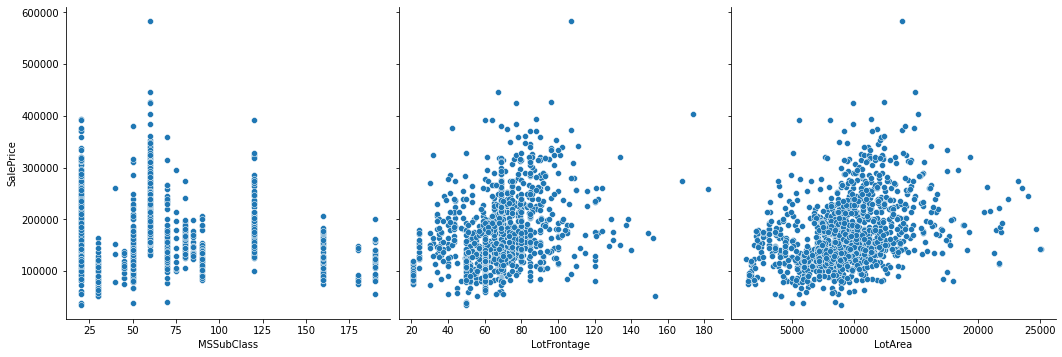

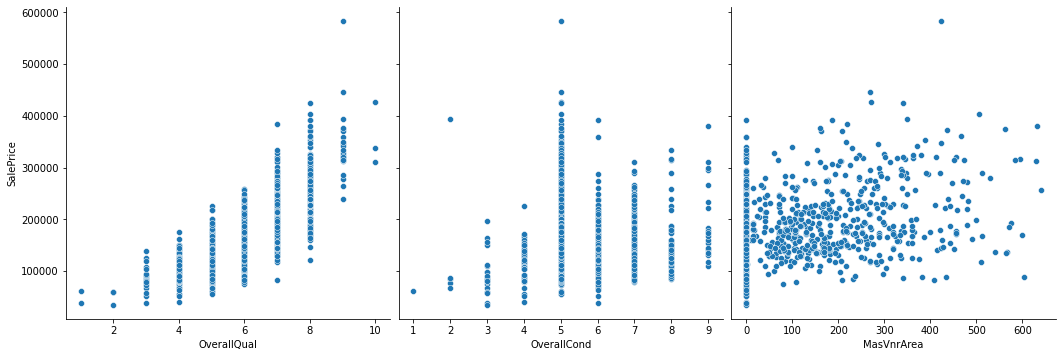

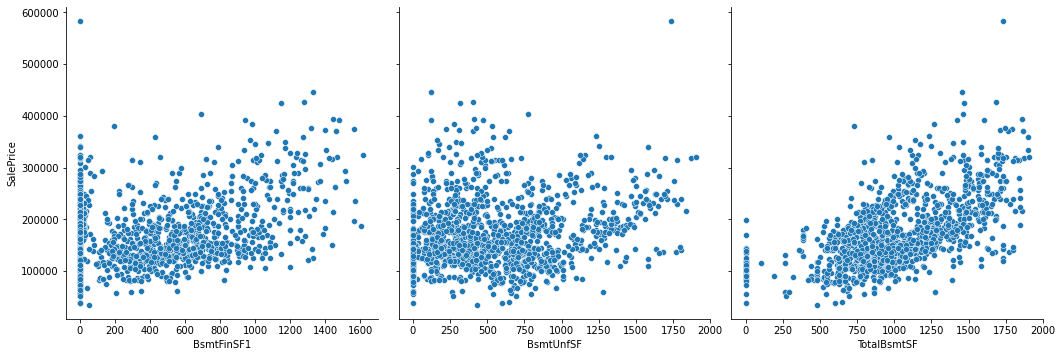

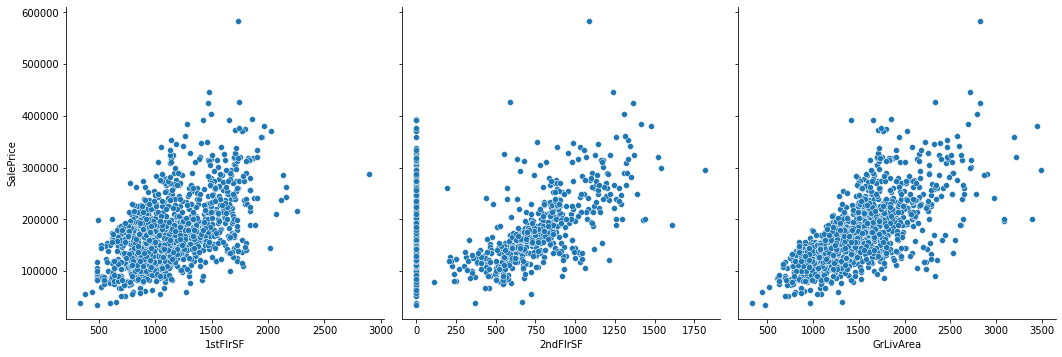

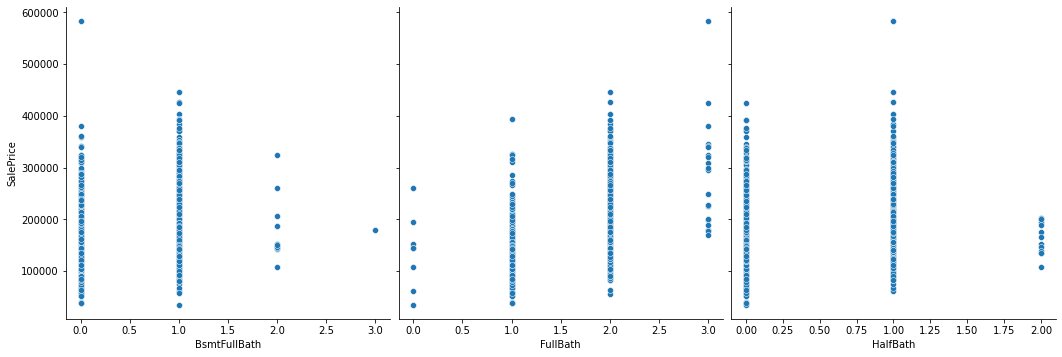

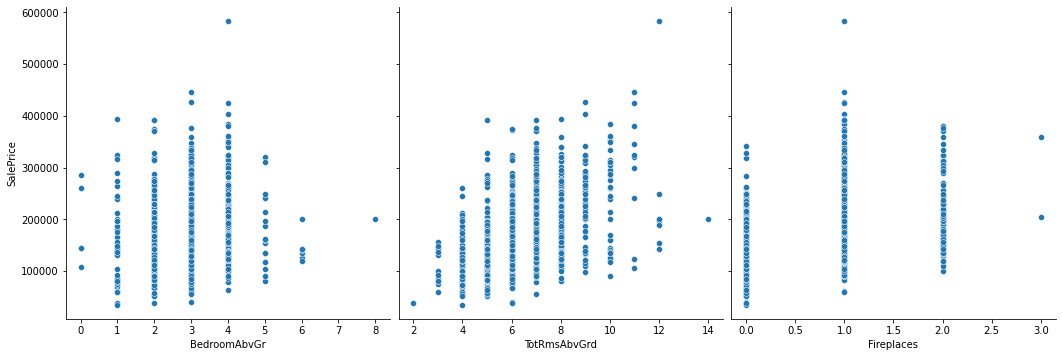

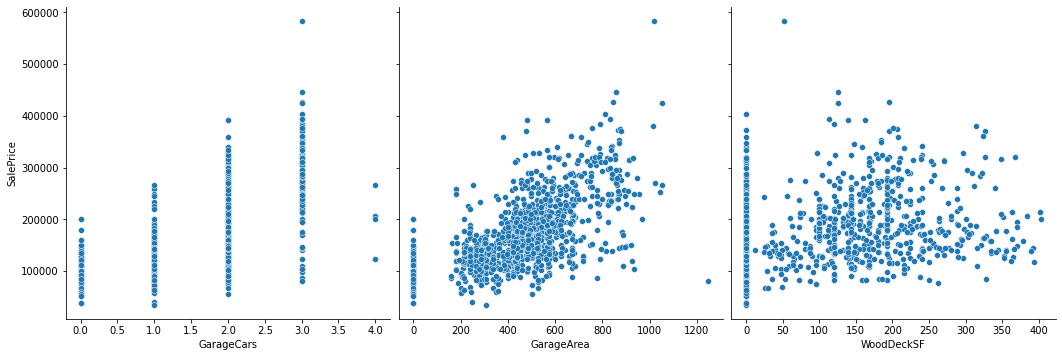

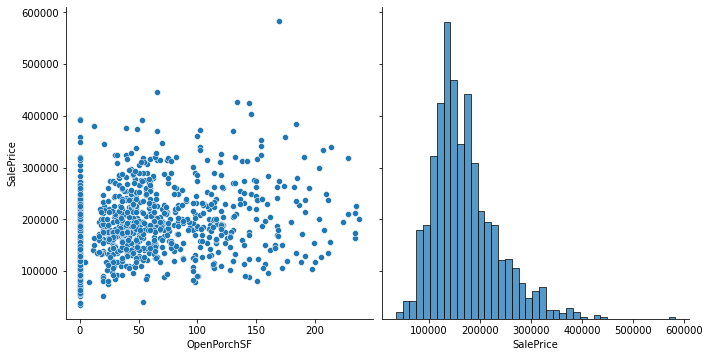

In [116]:
#Its important to see visual relationship between numerical columns with target variable 
# Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(data, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['OpenPorchSF','SalePrice'], y_vars='SalePrice',height=5, aspect=1,kind='scatter')
plt.show()

Note:
1)GrLivArea,TotalBsmntSF,Lot Area etc seem to be highly correllated with Prcie and are important variables to watch out for and on that note we need to look into correlations between different variables and heatmap could help in visualizing results

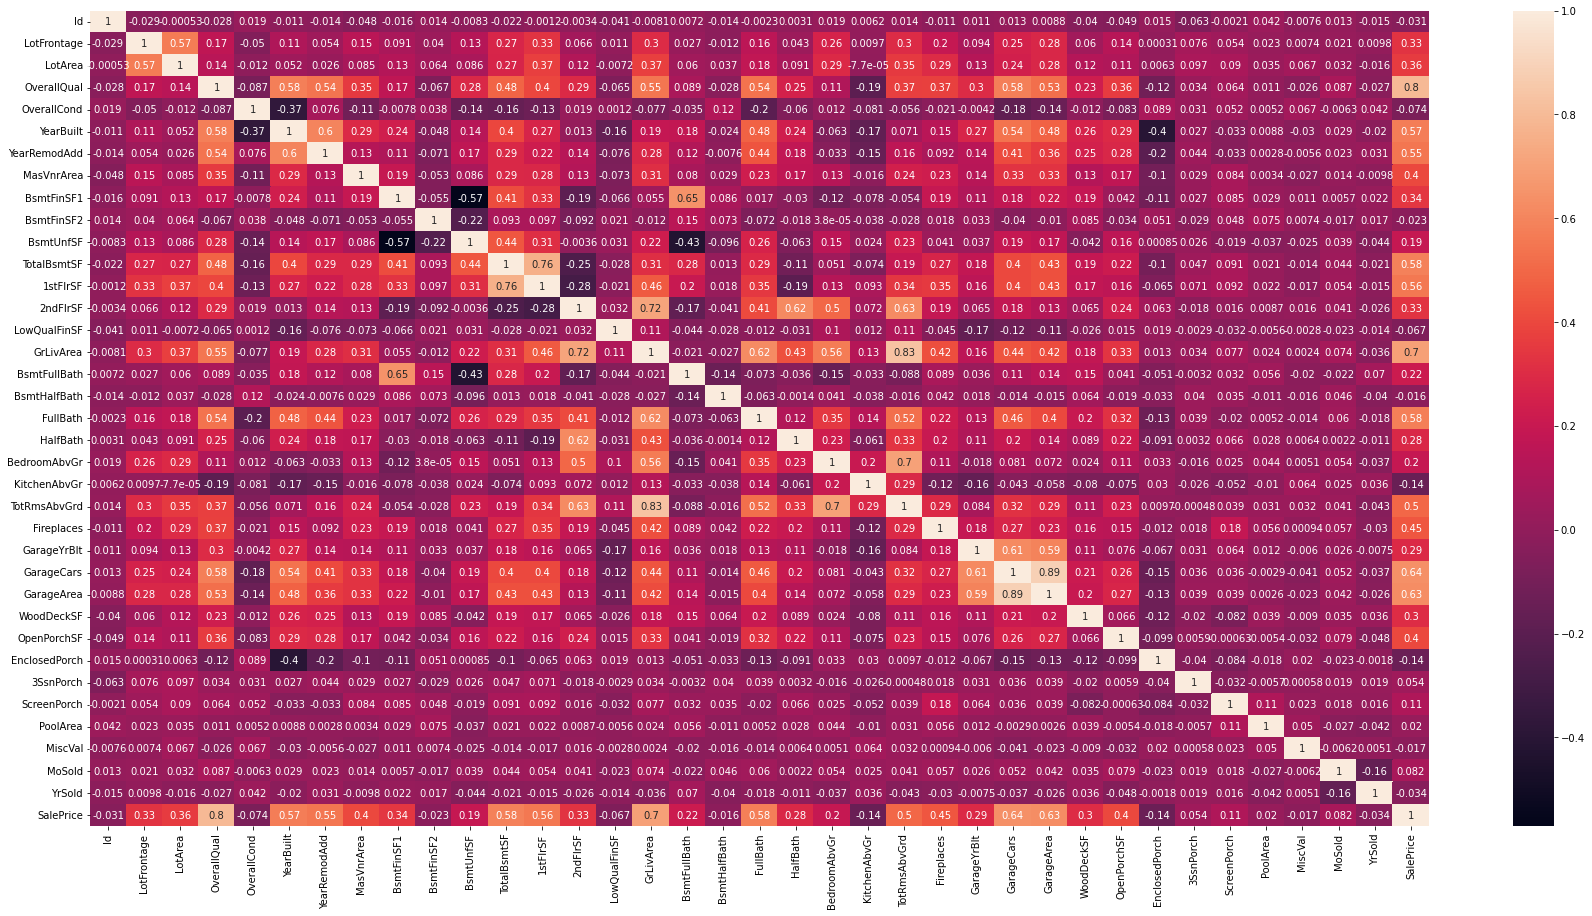

In [117]:
plt.figure(figsize = (30, 15))
sns.heatmap(data.corr(), annot = True)
plt.show()

As Regresssion assumptions need to be considered before running the model, any columns which are highly correlated should be taken of due to multi collinearity.Pairs that can identified are (TotRmsAbvGrd,GrLivArea),(GarageArea,GarageCars)

In [118]:
#Dropping one of columns in each pair in above idetified tuples
data.drop(['TotRmsAbvGrd','GarageCars'], axis = 1, inplace = True)

Next step is to encode categorical data into numerical data for regression

In [119]:
data_cat= data.select_dtypes(include= 'object')
data_num= data.select_dtypes(exclude= 'object')
#1,0 as encoding for columns having only two values
data['Street']= data.Street.map(lambda x: 1 if x== 'Pave' else 0)
data['Utilities']= data.Utilities.map(lambda x: 1 if x== 'AllPub' else 0)
data['CentralAir']= data.CentralAir.map(lambda x: 1 if x== 'Y' else 0)
cat_cols= data_cat.columns.tolist()
encoded= ['Street','Utilities', 'CentralAir']
cat_cols= [col for col in cat_cols if col not in encoded]
dummies= pd.get_dummies(data[cat_cols], drop_first=True)
data.drop(cat_cols, axis=1, inplace= True)
data= pd.concat([data, dummies], axis= 1)


In [120]:
data.dtypes

Id                         int64
LotFrontage              float64
LotArea                    int64
Street                     int64
Utilities                  int64
                          ...   
SaleCondition_AdjLand      uint8
SaleCondition_Alloca       uint8
SaleCondition_Family       uint8
SaleCondition_Normal       uint8
SaleCondition_Partial      uint8
Length: 255, dtype: object

In [121]:
#Dropping Id column as it doesn't have relevance
data.drop('Id',axis=1,inplace=True)

Now as all cleaning is done, perform test train split

In [122]:

df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=100)


In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Scaling numeric columns
numeric_cols = list(df_train.select_dtypes(include=['int64', 'float64']).columns)
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_train.head()

,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Not_Available,GarageFinish_Not_Available,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Not_Available,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Not_Available,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_Not_Available,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
16,0.298137,0.417777,1.0,1.0,0.555556,0.750,0.703704,0.333333,0.28125,0.357011,0.0,0.223622,0.527034,1.0,0.261310,0.000000,0.0,0.215226,0.5,0.0,0.333333,0.0,0.250,0.333333,0.333333,0.980100,0.455840,0.000000,0.000000,0.0,0.0,0.0,0.0,0.045161,0.181818,1.00,0.203841,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
291,0.211180,0.184366,1.0,1.0,0.444444,0.625,0.274074,0.833333,0.00000,0.129710,0.0,0.299213,0.409449,0.0,0.234789,0.506494,0.0,0.443945,0.5,0.0,0.666667,0.0,0.750,0.333333,0.000000,0.000000,0.000000,0.000000,0.773109,0.0,0.0,0.0,0.0,0.000000,0.181818,0.50,0.179806,0,0,0,...,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
401,0.273292,0.313805,1.0,1.0,0.666667,0.500,0.962963,0.916667,0.00000,0.014824,0.0,0.675066,0.687664,1.0,0.380655,0.000000,0.0,0.313524,0.0,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.997512,0.379867,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.545455,0.00,0.233179,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
427,0.347826,0.306493,1.0,1.0,0.333333,0.625,0.607407,0.116667,0.00000,0.177888,0.0,0.324934,0.476115,1.0,0.223479,0.000000,0.0,0.184067,0.0,0.0,0.333333,0.0,0.375,0.333333,0.000000,0.977114,0.334283,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.545455,0.50,0.130465,0,0,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1285,0.180124,0.197520,1.0,1.0,0.555556,0.625,0.474074,0.000000,0.00000,0.000000,0.0,0.409449,0.409449,1.0,0.191498,0.381169,0.0,0.346290,0.0,0.0,0.333333,0.0,0.500,0.333333,0.333333,0.964677,0.265907,0.111663,0.000000,0.0,0.0,0.0,0.0,0.000000,0.363636,0.75,0.173567,0,0,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [124]:
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [125]:
X_train = df_train.drop(['SalePrice'], axis=1)
y_train=df_train['SalePrice']
X_test=df_test.drop(['SalePrice'], axis=1)
y_test=df_test['SalePrice']

RIDGE REGRESSION

In [126]:
# Selecting few values for alpha
range1= [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
range2= list(range(2, 1001))
range1.extend(range2)
params_grid= {'alpha': range1}
ridge= Ridge(random_state= 42)
gcv_ridge= GridSearchCV(estimator= ridge, 
                        param_grid= params_grid,
                        cv= 3,
                        scoring= 'neg_mean_absolute_error',
                        return_train_score= True,
                        n_jobs= -1,
                        verbose= 1)      
gcv_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 1013 candidates, totalling 3039 fits


GridSearchCV(cv=3, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 3, 4,
                                   5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                   17, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [127]:
gcv_ridge.best_estimator_

Ridge(alpha=4, random_state=42)

In [128]:
gcv_ridge.best_score_

-0.025913946007299484

Using best_estimator to build model

In [129]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
ridge_model= gcv_ridge.best_estimator_
ridge_model.fit(X_train, y_train)
Ridge(alpha=4, random_state=42)
# Evaluating training dataset
y_train_pred= ridge_model.predict(X_train)
print( 'r2 score train set:', r2_score(y_train, y_train_pred))
print( 'MSE on train set:', mean_squared_error(y_train, y_train_pred))
print( 'RMSE on train set:', (mean_squared_error(y_train, y_train_pred)**.5))
print( 'MAE on train set:', mean_absolute_error(y_train, y_train_pred))
# Evaluating testing dataset
y_test_pred= ridge_model.predict(X_test)
print( 'r2 score on test set:', r2_score(y_test, y_test_pred))
print( 'MSE on test set:', mean_squared_error(y_test, y_test_pred))
print( 'RMSE on test set:', (mean_squared_error(y_test, y_test_pred)**.5))
print( 'MAE on test set:', mean_absolute_error(y_test, y_test_pred))

r2 score train set: 0.9329062255165088
MSE on train set: 0.0009578450192162381
RMSE on train set: 0.030949071378899854
MAE on train set: 0.020775004282147114
r2 score on test set: 0.8995633557360677
MSE on test set: 0.0012156431981029249
RMSE on test set: 0.034866075174916446
MAE on test set: 0.025629757335931595


In [130]:
ridge_model.coef_

array([ 0.02242544,  0.03095164,  0.00234234,  0.00569324,  0.08222292,
        0.04256287,  0.03132682,  0.01781631,  0.01053953,  0.04496696,
        0.02016308,  0.01649398,  0.07031124,  0.00787287,  0.07447456,
        0.07255624,  0.00285854,  0.09771882,  0.01682102, -0.00071852,
        0.02448967,  0.00691808, -0.00064543, -0.01186634,  0.02180328,
       -0.00053508,  0.06076346,  0.01241793,  0.01184638,  0.0053763 ,
        0.0158299 ,  0.02251089,  0.01098079, -0.00031582,  0.00069813,
       -0.00050542, -0.00183856,  0.01378261,  0.00362845,  0.00197224,
        0.01250217,  0.0095302 , -0.01046387, -0.0048556 , -0.00340786,
       -0.01467651, -0.00813134, -0.01660771, -0.00143255, -0.00873153,
        0.0196658 ,  0.00964016,  0.01533623,  0.00431015, -0.00334373,
       -0.00127604,  0.00416555,  0.01122137, -0.01389271,  0.00052349,
        0.0121122 , -0.01147585, -0.00435852, -0.00239205,  0.00723371,
       -0.02337263,  0.00343285,  0.0129255 ,  0.00581062, -0.01

In [131]:
ridge_model.intercept_

-0.05655146680452097

In [132]:
# Top 10 features with double the value of optimal alpha in Ridge
coef= pd.Series(ridge_model.coef_, index= X_train.columns)
ridge_20=  coef[abs(coef).nlargest(20).index]
ridge_20

GrLivArea               0.097719
OverallQual             0.082223
1stFlrSF                0.074475
2ndFlrSF                0.072556
TotalBsmtSF             0.070311
GarageArea              0.060763
Neighborhood_StoneBr    0.046350
BsmtFinSF1              0.044967
OverallCond             0.042563
KitchenQual_TA         -0.035629
KitchenQual_Gd         -0.034521
BsmtQual_Gd            -0.032775
Neighborhood_NoRidge    0.031873
YearBuilt               0.031327
LotArea                 0.030952
BsmtQual_TA            -0.030368
ExterQual_TA           -0.030320
BsmtExposure_Gd         0.029555
Neighborhood_Crawfor    0.029034
KitchenQual_Fa         -0.028776
dtype: float64

Note: Top features are 
GrLivArea 
OverallQual             
1stFlrSF               
2ndFlrSF                
TotalBsmtSF

LASSO REGRESSION

In [133]:
params_grid= {'alpha': range1}
lasso= Lasso(random_state= 42)
lasso_gcv= GridSearchCV(estimator= lasso, 
                        param_grid= params_grid,
                        cv= 3,
                        scoring= 'neg_mean_absolute_error',
                        return_train_score= True,
                        n_jobs= -1,
                        verbose= 1)

lasso_gcv.fit(X_train, y_train)
lasso_gcv.best_estimator_


Fitting 3 folds for each of 1013 candidates, totalling 3039 fits


Lasso(alpha=0.0001, random_state=42)

In [134]:
#As best alpha turns out be 0.0001
Lasso(alpha=0.0001, random_state=42)
lasso_gcv.best_score_

-0.025632382514435757

In [135]:
lasso_model= lasso_gcv.best_estimator_
lasso_model.fit(X_train, y_train)
Lasso(alpha=0.0001, random_state=42)
y_train_pred= lasso_model.predict(X_train)
print( 'r2 score on train set:', r2_score(y_train, y_train_pred))
print( 'MSE on train set:', mean_squared_error(y_train, y_train_pred))
print( 'RMSE on train set:', (mean_squared_error(y_train, y_train_pred)**.5))
print( 'MAE on train set:', mean_absolute_error(y_train, y_train_pred))
# Evaluating on testing dataset
y_test_pred= lasso_model.predict(X_test)
print( 'r2 score on test set:', r2_score(y_test, y_test_pred))
print( 'MSE on test set:', mean_squared_error(y_test, y_test_pred))
print( 'RMSE on test set:', (mean_squared_error(y_test, y_test_pred)**.5))
print( 'MAE on test set:', mean_absolute_error(y_test, y_test_pred))

r2 score on train set: 0.9305097131236931
MSE on train set: 0.000992058140725944
RMSE on train set: 0.03149695446747104
MAE on train set: 0.021351065139852653
r2 score on test set: 0.901442855776143
MSE on test set: 0.0011928945145293515
RMSE on test set: 0.03453830503266412
MAE on test set: 0.025559662706123448


In [136]:
#Top features in Lassso
lasso_coef= pd.Series(lasso_model.coef_, index= X_train.columns)
lasso20=  lasso_coef[abs(lasso_coef[lasso_coef != 0]).nlargest(20).index]
lasso20

GrLivArea               0.263832
OverallQual             0.118785
TotalBsmtSF             0.079547
OverallCond             0.062059
GarageArea              0.060684
YearBuilt               0.056170
Neighborhood_StoneBr    0.052078
Neighborhood_Crawfor    0.040101
Neighborhood_NoRidge    0.037455
KitchenQual_TA         -0.035625
KitchenQual_Gd         -0.034064
BsmtQual_Gd            -0.033309
SaleType_New            0.033253
BsmtFinSF1              0.033181
KitchenQual_Fa         -0.033094
Exterior1st_BrkFace     0.031457
BsmtExposure_Gd         0.030232
BsmtQual_TA            -0.030065
Neighborhood_NridgHt    0.027877
MSSubClass_90          -0.027801
dtype: float64

NOTE
Considering Both models have similar train and test r2 scores but lasso slightly out performs ridge regression. Lasso also removes more features which are unnecessary and gives due weigtage to top features which makes identifying important features easier and makes model less complex. So Lasso can be considered as better choice here